# CESM-LE biomass shifts in the Southern Ocean on a seasonal cycle

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the 1920s segment

In [6]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint']

ds_list = []
ds_1920s = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_monthly_1920s.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_1920s = xr.merge((ds_1920s, dsv))
    ds_list.append(ds_1920s)

diatC_zint
spC_zint
zooC_zint
CPU times: user 266 ms, sys: 8.98 ms, total: 275 ms
Wall time: 472 ms


### get the 2090s segment

In [8]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint']

ds_list = []
ds_2090s = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_monthly_2090s.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_2090s = xr.merge((ds_2090s, dsv))
    ds_list.append(ds_2090s)

diatC_zint
spC_zint
zooC_zint
CPU times: user 280 ms, sys: 6.25 ms, total: 286 ms
Wall time: 621 ms


### calculate a couple extra fields

In [9]:
ds_1920s['mesozooC'] = ds_1920s.zooC_zint * (ds_1920s.diatC_zint/(ds_1920s.diatC_zint + ds_1920s.spC_zint))
ds_1920s['diat_frac'] = ds_1920s.diatC_zint/(ds_1920s.diatC_zint + ds_1920s.spC_zint)
ds_1920s['phytoC'] = ds_1920s.diatC_zint + ds_1920s.spC_zint

In [10]:
ds_2090s['mesozooC'] = ds_2090s.zooC_zint * (ds_2090s.diatC_zint/(ds_2090s.diatC_zint + ds_2090s.spC_zint))
ds_2090s['diat_frac'] = ds_2090s.diatC_zint/(ds_2090s.diatC_zint + ds_2090s.spC_zint)
ds_2090s['phytoC'] = ds_2090s.diatC_zint + ds_2090s.spC_zint

In [11]:
## redefine variable list to include these
variables = ['diatC_zint','spC_zint','zooC_zint','mesozooC','diat_frac','phytoC']

### get pop grid

In [12]:
grid = pop_tools.get_grid('POP_gx1v6')

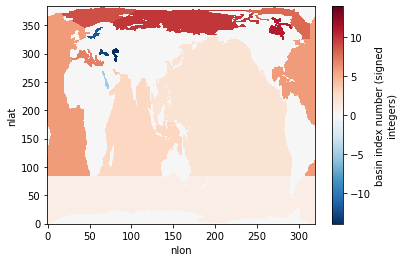

In [13]:
grid.REGION_MASK.plot()

In [14]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA

### mask out nans in ds

In [15]:
ds_1920s = ds_1920s.where(grid.REGION_MASK>0)
ds_2090s = ds_2090s.where(grid.REGION_MASK>0)

### make ensemble mean

In [18]:
#ds_1920s_ens_mean = ds_1920s.mean(dim='member_id')
#ds_2090s_ens_mean = ds_2090s.mean(dim='member_id')

### Make monthly climatology

In [19]:
ds_1920s_monthly_clim = ds_1920s.groupby('time.month').mean('time')
ds_2090s_monthly_clim = ds_2090s.groupby('time.month').mean('time')

In [20]:
ds_1920s_monthly_clim

<xarray.Dataset>
Dimensions:     (member_id: 34, month: 12, nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id   (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT         (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA       (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz          (month, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    diatC_zint  (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>
    spC_zint    (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>
    zooC_zint   (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>
    mesozooC    (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>
    diat_frac   (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>
    phytoC      (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 34, 384, 320), meta=np.ndarray>

### mask regions of the Southern Ocean: ACC and SIZ

In [21]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1920s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

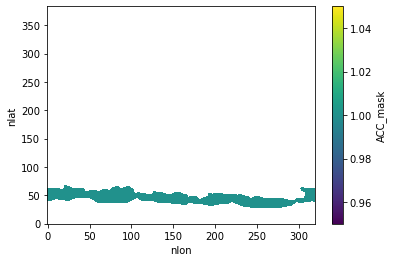

In [22]:
ds_masks.ACC_mask.plot()

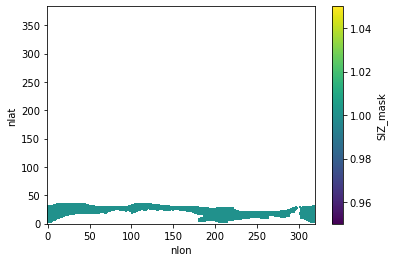

In [23]:
ds_masks.SIZ_mask.plot()

### spin up dask cause the next few cells could take awhile

In [24]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='256 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(8)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [25]:
client

Client Scheduler: tcp://10.12.206.9:46215 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [26]:
ts_1920s_ACC = xr.Dataset({v: ds_1920s_monthly_clim[v] for v in ['month']})
ts_2090s_ACC = xr.Dataset({v: ds_2090s_monthly_clim[v] for v in ['month']})


for var in variables:
    masked = ds_1920s_monthly_clim[var].where(ds_masks.ACC_mask==1.)
    ts_1920s_ACC[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_2090s_monthly_clim[var].where(ds_masks.ACC_mask==1.)
    ts_2090s_ACC[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_1920s_ACC = xr.concat([ts_1920s_ACC,ts_1920s_ACC.isel(month=slice(0,6))],dim='month')
ts_2090s_ACC = xr.concat([ts_2090s_ACC,ts_2090s_ACC.isel(month=slice(0,6))],dim='month')

In [ ]:
ts_1920s_SIZ = xr.Dataset({v: ds_1920s_monthly_clim[v] for v in ['month']})
ts_2090s_SIZ = xr.Dataset({v: ds_2090s_monthly_clim[v] for v in ['month']})


for var in variables:
    print(var)
    masked = ds_1920s_monthly_clim[var].where(ds_masks.SIZ_mask ==1.)
    ts_1920s_SIZ[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_2090s_monthly_clim[var].where(ds_masks.SIZ_mask ==1.)
    ts_2090s_SIZ[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_1920s_SIZ = xr.concat([ts_1920s_SIZ,ts_1920s_SIZ.isel(month=slice(0,6))],dim='month')
ts_2090s_SIZ = xr.concat([ts_2090s_SIZ,ts_2090s_SIZ.isel(month=slice(0,6))],dim='month')

diatC_zint
spC_zint
zooC_zint
mesozooC
diat_frac
phytoC


In [25]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
xvals = np.arange(1,19,1)

### Plot shifts in phytplankton biomass

In [34]:
ts_2090s_SIZ_anoms = ts_2090s_SIZ - ts_1920s_SIZ

In [35]:
ts_2090s_ACC_anoms = ts_2090s_ACC - ts_1920s_ACC

In [36]:
xvals = [7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,18]

In [37]:
xlabels = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']

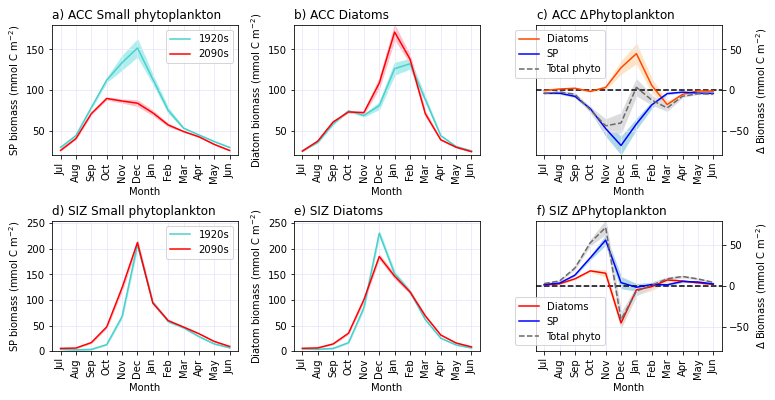

In [83]:
fig = plt.figure(figsize=(12,6))

######################################################## ACC top row
########## ACC small phytoplankton

ax1 = fig.add_subplot(2,3,1)
ax1.set_title('a) ACC Small phytoplankton',fontsize=12,loc='left')
ax1.set_ylabel('SP biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920
ax1.plot(xvals,ts_1920s_ACC['spC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='mediumturquoise', label='1920s', lw=1.5)
error = ts_1920s_ACC['spC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_1920s_ACC['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_1920s_ACC['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='paleturquoise')


#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['spC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='red', label='2090s', lw=1.5)
error = ts_2090s_ACC['spC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_ACC['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_ACC['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='pink')

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()
########## ACC diatoms

ax1 = fig.add_subplot(2,3,2)
ax1.set_title('b) ACC Diatoms',fontsize=12,loc='left')
ax1.set_ylabel('Diatom biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='mediumturquoise', label='1920s', lw=1.5)
error = ts_1920s_ACC['diatC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_1920s_ACC['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_1920s_ACC['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='paleturquoise')


#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='red', label='2090s', lw=1.5)
error = ts_2090s_ACC['diatC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_ACC['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_ACC['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='pink')


plt.xticks(xvals, xlabels, rotation='vertical');

########## delta ACC sp/diatoms
ax1 = fig.add_subplot(2,3,3)
ax1.set_title('c) ACC ${\Delta}$Phytoplankton',fontsize=12,loc='left')
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-80,80)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

plt.axhline(y=0, color='black', linestyle='--')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_ACC_anoms['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='orangered', label='Diatoms',lw=1.5)
error = ts_2090s_ACC_anoms['diatC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_ACC_anoms['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_ACC_anoms['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='bisque',zorder=1)

#plot 2090s anomalies sp
ax1.plot(xvals,ts_2090s_ACC_anoms['spC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='blue', label='SP',lw=1.5)
error = ts_2090s_ACC_anoms['spC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_ACC_anoms['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_ACC_anoms['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='lightblue')

#plot 2090s anomalies tot phyto
ax1.plot(xvals,ts_2090s_ACC_anoms['phytoC'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='dimgray', label='Total phyto',lw=1.5, linestyle='--')
error = ts_2090s_ACC_anoms['phytoC'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_ACC_anoms['phytoC'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_ACC_anoms['phytoC'].mean(dim='member_id').isel(month=slice(6,18))+error,color='gainsboro',zorder=1)

ax1.legend(bbox_to_anchor=(0.4, 1))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
plt.xticks(xvals, xlabels, rotation='vertical')

######################################################## SIZ bottom row
########## small phytoplankton

ax1 = fig.add_subplot(2,3,4)
ax1.set_title('d) SIZ Small phytoplankton',fontsize=12,loc='left')
ax1.set_ylabel('SP biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,255)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right()

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['spC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='mediumturquoise', label='1920s', lw=1.5)
error = ts_1920s_SIZ['spC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_1920s_SIZ['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_1920s_SIZ['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='paleturquoise')

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['spC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='red', label='2090s', lw=1.5)
error = ts_2090s_SIZ['spC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_SIZ['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_SIZ['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='pink')
ax1.legend()
plt.xticks(xvals, xlabels, rotation='vertical')


########## SIZ diatoms

ax1 = fig.add_subplot(2,3,5)
ax1.set_title('e) SIZ Diatoms',fontsize=12,loc='left')
ax1.set_ylabel('Diatom biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,255)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='mediumturquoise', label='1920s', lw=1.5)
error = ts_1920s_SIZ['diatC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_1920s_SIZ['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_1920s_SIZ['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='paleturquoise')
#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='red', label='2090s', lw=1.5)
error = ts_2090s_SIZ['diatC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_SIZ['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_SIZ['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='pink')
plt.xticks(xvals, xlabels, rotation='vertical')

plt.subplots_adjust(hspace=0.4,wspace=0.1)
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right();


########## delta SIZ sp/diatoms

ax1 = fig.add_subplot(2,3,6)
ax1.set_title('f) SIZ ${\Delta}$Phytoplankton',fontsize=12,loc='left')
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-80,80)
plt.axhline(y=0, color='black', linestyle='--')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_SIZ_anoms['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='red', label='Diatoms',lw=1.5)
error = ts_2090s_SIZ_anoms['diatC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_SIZ_anoms['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_SIZ_anoms['diatC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='bisque',zorder=1)

#plot 2090s anomalies sp
ax1.plot(xvals,ts_2090s_SIZ_anoms['spC_zint'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='blue', label='SP',lw=1.5)
error = ts_2090s_SIZ_anoms['spC_zint'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_SIZ_anoms['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_SIZ_anoms['spC_zint'].mean(dim='member_id').isel(month=slice(6,18))+error,color='lightblue',zorder=1)

#plot 2090s anomalies tot phyto
ax1.plot(xvals,ts_2090s_SIZ_anoms['phytoC'].mean(dim='member_id').isel(month=slice(6,18)), 
         color='dimgray', label='Total phyto',lw=1.5, linestyle='--')
error = ts_2090s_SIZ_anoms['phytoC'].std(dim='member_id').isel(month=slice(6,18))
ax1.fill_between(xvals, ts_2090s_SIZ_anoms['phytoC'].mean(dim='member_id').isel(month=slice(6,18))-error, 
                 ts_2090s_SIZ_anoms['phytoC'].mean(dim='member_id').isel(month=slice(6,18))+error,color='gainsboro',zorder=1)

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();
ax1.legend(bbox_to_anchor=(0.4, 0.45))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/fig3_seas_cycle_v3.png', bbox_inches='tight', dpi=300, format='png');

### Zooplankton figure?

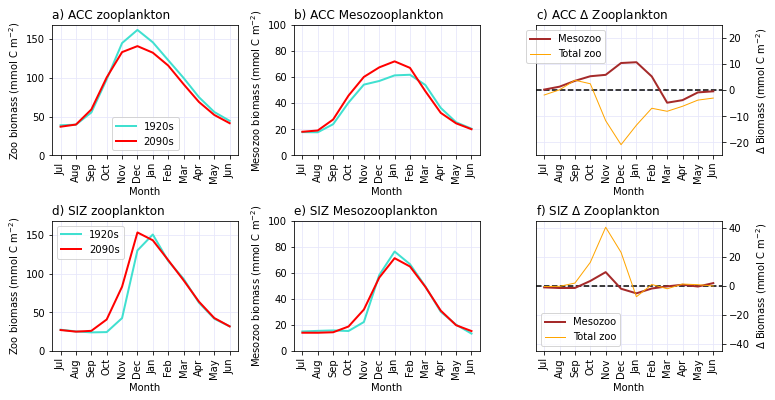

In [40]:
fig = plt.figure(figsize=(12,6))


######################################################## ACC top row
########## ACC all zoo

ax1 = fig.add_subplot(2,3,1)
ax1.set_title('a) ACC zooplankton',fontsize=12,loc='left')
ax1.set_ylabel('Zoo biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['zooC_zint'].isel(month=slice(6,18)), 
         color='turquoise', label='1920s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['zooC_zint'].isel(month=slice(6,18)), 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()

########## ACC mesozoo

ax1 = fig.add_subplot(2,3,2)
ax1.set_title('b) ACC Mesozooplankton',fontsize=12,loc='left')
ax1.set_ylabel('Mesozoo biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,100)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['mesozooC'].isel(month=slice(6,18)), 
         color='turquoise', label='1920s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['mesozooC'].isel(month=slice(6,18)), 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');

########## delta zoo
ax1 = fig.add_subplot(2,3,3)
ax1.set_title('c) ACC ${\Delta}$ Zooplankton',fontsize=12,loc='left')
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-25,25)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

plt.axhline(y=0, color='black', linestyle='--')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_ACC_anoms['mesozooC'].isel(month=slice(6,18)), 
         color='brown', label='Mesozoo',lw=2)


#plot 2090s anomalies tot zoo
ax1.plot(xvals,ts_2090s_ACC_anoms['zooC_zint'].isel(month=slice(6,18)), 
         color='orange', label='Total zoo',lw=1)

ax1.legend(bbox_to_anchor=(0.4, 1))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
plt.xticks(xvals, xlabels, rotation='vertical');


######################################################## SIZ bottom row
########## ACC all zoo

ax1 = fig.add_subplot(2,3,4)
ax1.set_title('d) SIZ zooplankton',fontsize=12,loc='left')
ax1.set_ylabel('Zoo biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['zooC_zint'].isel(month=slice(6,18)), 
         color='turquoise', label='1920s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['zooC_zint'].isel(month=slice(6,18)), 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend()

########## ACC mesozoo

ax1 = fig.add_subplot(2,3,5)
ax1.set_title('e) SIZ Mesozooplankton',fontsize=12,loc='left')
ax1.set_ylabel('Mesozoo biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,100)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['mesozooC'].isel(month=slice(6,18)), 
         color='turquoise', label='1920s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['mesozooC'].isel(month=slice(6,18)), 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');

########## delta zoo
ax1 = fig.add_subplot(2,3,6)
ax1.set_title('f) SIZ ${\Delta}$ Zooplankton',fontsize=12,loc='left')
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-45,45)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

plt.axhline(y=0, color='black', linestyle='--')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_SIZ_anoms['mesozooC'].isel(month=slice(6,18)), 
         color='brown', label='Mesozoo',lw=2)


#plot 2090s anomalies tot zoo
ax1.plot(xvals,ts_2090s_SIZ_anoms['zooC_zint'].isel(month=slice(6,18)), 
         color='orange', label='Total zoo',lw=1)

ax1.legend(loc='lower left')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
plt.xticks(xvals, xlabels, rotation='vertical');

plt.subplots_adjust(wspace=0.3, hspace=0.5);


fig.savefig('/glade/work/kristenk/figs/fig4_zoo_seas_cycle_v3.png', bbox_inches='tight', dpi=300, format='png');